In [15]:
# test of global search setup
# notebook format for ease of modifications
# 2/23/23 - setup for exploration of end data

In [16]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from extremasearch.globalmm.globalsearch import MultimodalExtremaSearch
from botorch import fit_gpytorch_mll
from botorch.models.gp_regression import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood
import numpy as np
import networkx as nx
from botorch.models.transforms import Normalize, Standardize


# setup
dtype = torch.double
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import warnings
from botorch.exceptions import BadInitialCandidatesWarning
warnings.filterwarnings('ignore', category=BadInitialCandidatesWarning)
warnings.filterwarnings('ignore', category=RuntimeWarning)

In [17]:
# setup file i/o
import os as os
import datetime as dt
# get current working directory
wrkdir = os.getcwd()
print('Current working directory: '+wrkdir)
# set up a data save directory for all future runs
newoutputdir = wrkdir+'\output'
if not os.path.exists(newoutputdir):
    os.makedirs(newoutputdir)
# set up a new directory to store files for the current run - updates at each new full run of notebook
curDatetime = dt.datetime.now()
datasavedir = newoutputdir + r'\\' + 'mme_test' + str(curDatetime.strftime('%Y%m%d%H%M%S'))
if not os.path.exists(datasavedir):
    os.makedirs(datasavedir)
print('Data save directory: '+datasavedir)

Current working directory: C:\Users\alexb\PycharmProjects\extrema_search\src\notebooks
Data save directory: C:\Users\alexb\PycharmProjects\extrema_search\src\notebooks\output\\mme_test20230227102558


In [18]:
def mme_torch(x):
    x = x
    y = torch.zeros(x.shape)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) + torch.exp(-(100.*(x-0.65))**2.))
    y += 0.5 * ( torch.exp(-(100.*(x-0.35))**2.) )
    y += 0.4 * ( torch.exp(-(100.*(x-0.92))**2.) )
    y += 0.73
    return y

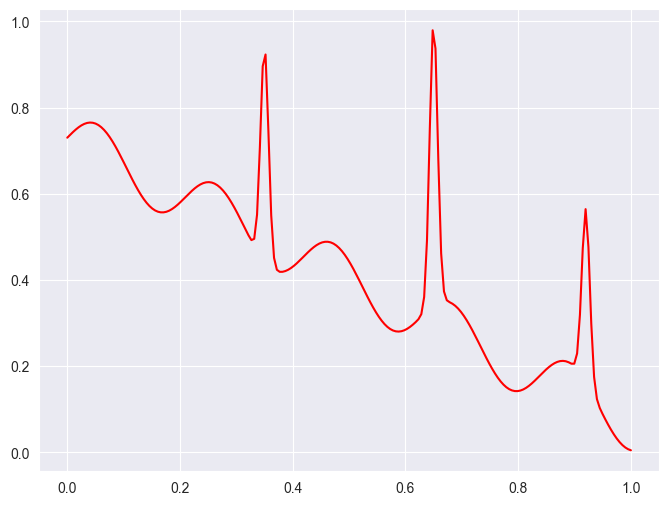

In [19]:
x1 = torch.linspace(0,1.0,200)
y1 = mme_torch(x1)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y1, ax=ax, color='r')
None

<AxesSubplot: >

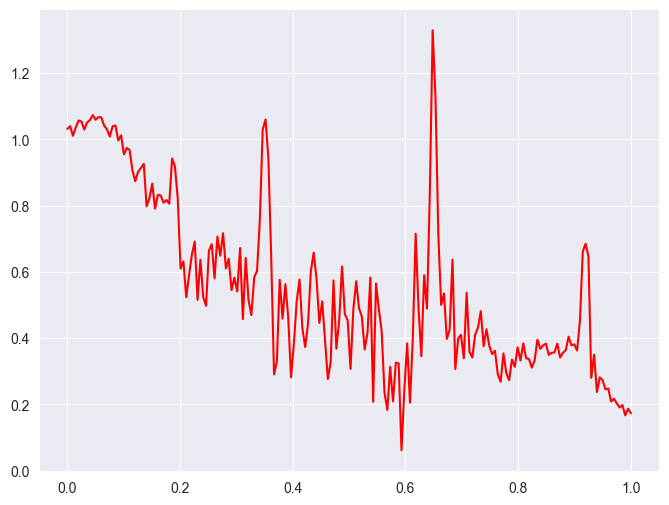

In [20]:
def mme_noise_jump_1d_mean(x):
    y = torch.zeros(x.shape)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) + torch.exp(-(100.*(x-0.65))**2.)) * (x >= 0.6)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) - 0.25 + torch.exp(-(100.*(x-0.65))**2.)) * (x < 0.6) * (x >= 0.2)
    y += 0.66*(-1.*x + 0.1*torch.sin(30.*x) + 0.2 + torch.exp(-(100.*(x-0.65))**2.)) * (x < 0.2)
    y += 0.7 * ( torch.exp(-(100.*(x-0.35))**2.) )
    y += 0.4 * ( torch.exp(-(100.*(x-0.92))**2.) )
    y += 0.9
    return y


sigma_max = 0.12
sigma_min = 0.02


def mme_noise_jump_1d(x):
    # mean
    y = mme_noise_jump_1d_mean(x)
    # noise
    noise = torch.zeros(x.shape)
    noise += (torch.randn(x.shape) * sigma_max) * (x >= 0.61) * (x < 0.71)
    noise += (torch.randn(x.shape) * 0.5*sigma_max) * (x >= 0.31) * (x < 0.41)
    noise += (torch.randn(x.shape) * 0.8*sigma_max) * (x >= 0.90) * (x < 0.94)
    noise += (torch.randn(x.shape) * (sigma_max - sigma_min) / (1. + torch.exp(-10.*(x-0.2))) )* (x < 0.61)
    noise += (torch.randn(x.shape) * (sigma_max - sigma_min) / (1. + torch.exp(10.*(x-0.75))) ) * (x >= 0.71)
    # combined
    y_out = y + noise
    # any_neg = y_out < 0
    # if any_neg:
    #     y_out = torch.tensor(0.0)
    return y_out


x1 = torch.linspace(0,1.0,200)
y1 = mme_noise_jump_1d(x1)
fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y1, ax=ax, color='r')

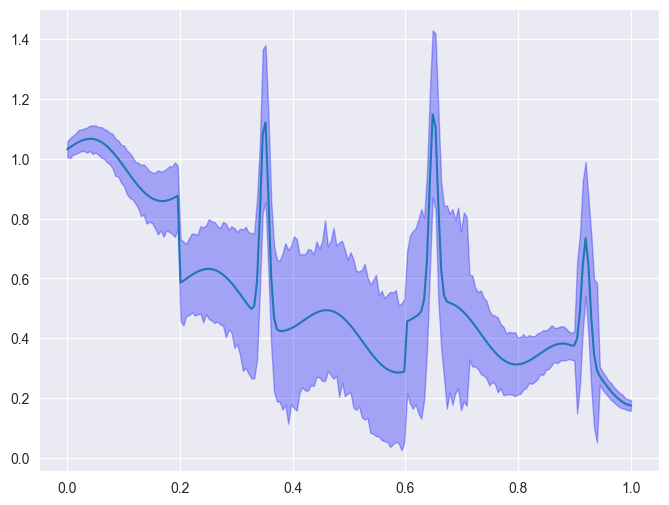

In [63]:
# plot noise bounds as 99% confidence interval
# generate realizations of the function
num_reals = 500
num_x = 200
x1 = torch.linspace(0,1.0,num_x)
y_reps = torch.DoubleTensor(num_x, num_reals)
y_deter = mme_noise_jump_1d_mean(x1)
for i in range(num_reals):
    y_reps[:,i] = mme_noise_jump_1d(x1)

fig, ax = plt.subplots(1, 1, figsize=(8,6))
sns.lineplot(x=x1, y=y_deter, ax=ax)
upper_99 = torch.quantile(y_reps, 0.995, dim=1)
lower_01 = torch.quantile(y_reps, 0.005, dim=1)
ax.fill_between(x1, lower_01, upper_99, color='b', alpha=0.3, label=r'99% quantiles')
# ax.set_ylim([0.7, 0.75])
# plt.savefig(datasavedir + '/'+'up_nonstat_function_fill'+'.png')

In [22]:
def outcome_objective(x):
    """wrapper for the outcome objective function"""
    # return mme_torch(X).type_as(X)
    return mme_noise_jump_1d(x).type_as(x)

In [23]:
test_global_bounds = torch.tensor([0.0, 1.0], dtype=dtype)
test_global_search = MultimodalExtremaSearch(60,test_global_bounds,outcome_objective,)
test_global_search.run_global_search()

Setting up global state
tead
tead
tead
tead
tead
tead
tead
tead
tead
tead
tead
Fitting global model
Exploring full space
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Completed: TEAD exploration iteration
Calculating pre-select scores
Calculating subdomain pre-select scores
PRESELECT: For node  0  tead score:  tensor(1.0342, dtype=torch.float64, grad_fn=<MaxBackward1>)
PRESELECT: Selecting node  0  for split with score  1.0341660244090318
Running partition
PARTITION: Splitting node  0  from  0.0  to  0.5  to  1.0
PARTITION: New node  1  new edge from  0  to  1
PARTITION: New node  2  new edge from  0  to  2
Running subdomain selection
SELECT: For node  1  best x:  0.09031327953188177  best tead:  1.199671377699842
SELECT: For node  2  best x:  0.9995112255544352  best tead:  0.8029101105443688
SELECT: Found  1  as best with score  1.199671377699842
Running local search
LOCALSEARCH:

In [24]:
def get_bounds(graph):
    """Get the bounds for each node in a graph to be able to plot them"""
    graph_leaves = [n for n in graph if graph.out_degree[n] == 0]
    bound_list = []
    node_list = []
    for n in graph_leaves:
        # get current leaf node
        current_node = graph.nodes()[n]
        current_state = current_node['data']
        current_bounds = current_state.local_bounds
        node_list.append(n)
        bound_list.append(current_bounds)
    return node_list, bound_list


def get_bounds_all(graph):
    """Get the bounds for each node in a graph to be able to plot them"""
    graph_nodes = [n for n in graph]
    bound_list = []
    node_list = []
    for n in graph_nodes:
        # get current node
        current_node = graph.nodes()[n]
        current_state = current_node['data']
        current_bounds = current_state.local_bounds
        node_list.append(n)
        bound_list.append(current_bounds)
    return node_list, bound_list


test_nodes, test_bounds = get_bounds(test_global_search.global_state.partition_graph)
all_nodes, all_bounds = get_bounds_all(test_global_search.global_state.partition_graph)

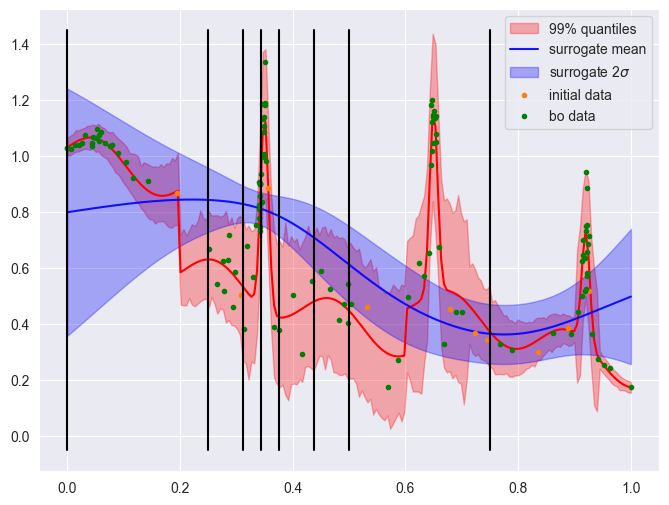

In [25]:
def plot_1d_results(mll: ExactMarginalLogLikelihood, model: SingleTaskGP, x_search, y_search, nodes, bnds):
    """Plot 1d results for experiment on multi-modal optimization"""
    fit_gpytorch_mll(mll)
    x_test = torch.linspace(0, 1, 400)
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    # true objective
    # ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
    sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
    upper_99 = torch.quantile(y_reps, 0.995, dim=1)
    lower_01 = torch.quantile(y_reps, 0.005, dim=1)
    ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
    # final model
    mean_test = model.posterior(x_test).mean.detach().numpy()
    ax.plot(x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
    var_test = model.posterior(x_test).variance.detach().numpy()
    sd_test = np.sqrt(var_test)
    upper_test = mean_test + 2.0*sd_test
    lower_test = mean_test - 2.0*sd_test
    ax.fill_between(x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3, label=r'surrogate 2$\sigma$')
    # training points
    ax.plot(x_search.numpy()[0:10], y_search[0:10].numpy(), '.', color='tab:orange', label='initial data')
    ax.plot(x_search.numpy()[10:], y_search[10:].numpy(), '.', color='g', label='bo data')
    # partitions
    for n, b in zip(nodes, bnds):
        ax.plot([b[0].numpy(), b[0].numpy()], [-0.05, 1.45], 'k-')
    ax.legend()
    plt.show()

# plot the results with the partitioning
plot_1d_results(test_global_search.global_state.global_mll, test_global_search.global_state.global_model,
                test_global_search.global_state.x_global, test_global_search.global_state.y_global,
                test_nodes, test_bounds)

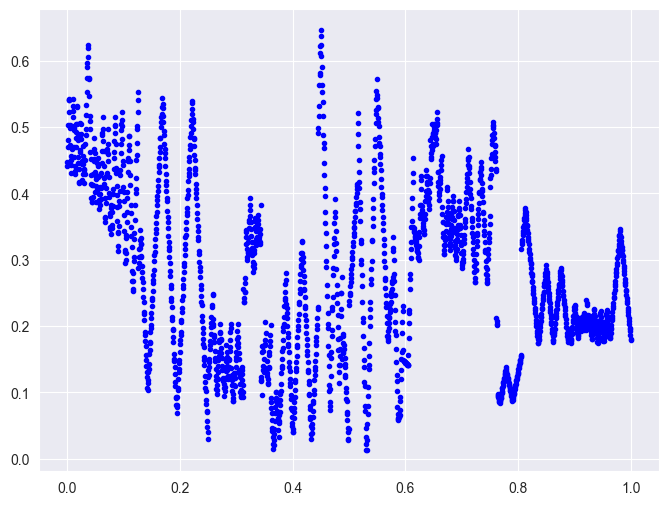

In [26]:
# tead global acq plot
test_x_cand = test_global_search.global_state.x_global_candidates
test_tead_scores = test_global_search.global_state.tead_global_scores

f, ax = plt.subplots(1,1, figsize=(8, 6))
ax.plot(test_x_cand.detach().numpy(), test_tead_scores.detach().numpy(), '.', color='b', label='tead scores')

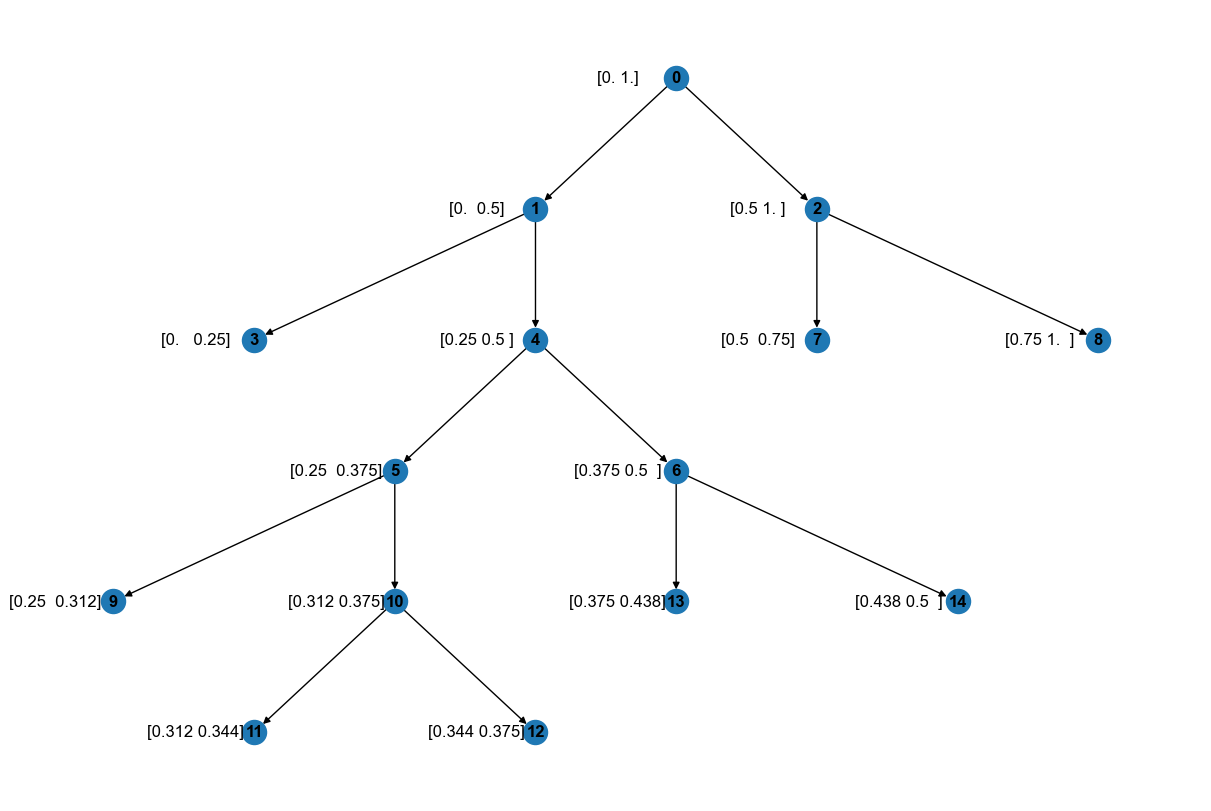

In [27]:
# tree figure
T = test_global_search.global_state.partition_graph
pos = nx.nx_agraph.graphviz_layout(T, prog="dot")

pos_attrs = {}
for node, coords in pos.items():
    pos_attrs[node] = (coords[0]-15, coords[1])
custom_node_attrs = {}
for node, attrs in zip(all_nodes, all_bounds):
    custom_node_attrs[node] = str(attrs.numpy().round(decimals=3))

f, ax = plt.subplots(1, 1, figsize=(12, 8), constrained_layout=True)
nx.draw(T, pos, with_labels=True, font_weight='bold', ax=ax)
nx.draw_networkx_labels(T, pos_attrs, labels=custom_node_attrs, ax=ax)
plt.show()

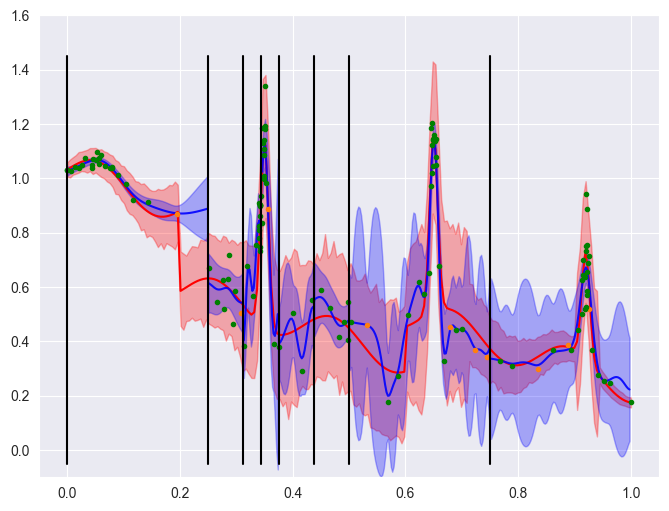

In [65]:
# fit the local models
def fit_local_models(graph):
    """Go through leaf nodes and update LocalSearchState to have local {x, y}
    based on global {x, y} that are within bounds"""
    graph_leaves = [n for n in graph if graph.out_degree[n] == 0]
    for n in graph_leaves:
        current_node = graph.nodes()[n]
        current_state = current_node['data']
        current_state.local_model = SingleTaskGP(current_state.x_local, current_state.y_local,
                                                 input_transform=Normalize(d=current_state.x_local.shape[-1]),
                                                 outcome_transform=Standardize(m=current_state.y_local.shape[-1]))
        current_state.local_mll = ExactMarginalLogLikelihood(current_state.local_model.likelihood,
                                                             current_state.local_model)
        fit_gpytorch_mll(current_state.local_mll)


g = test_global_search.global_state.partition_graph
fit_local_models(g)


# plot the local models
def plot_local_models_1d(graph, x_search, y_search, nodes, bnds):
    """Go through leaf nodes and plot the local models only within the bounds of the node"""
    x_test = torch.linspace(0, 1, 400)
    f, ax = plt.subplots(1, 1, figsize=(8, 6))
    # true objective
    # ax.plot(x_test.numpy(), outcome_objective(x_test).numpy(), 'r-', alpha=0.9, label='true objective')
    sns.lineplot(x=x1, y=y_deter, ax=ax, color='r')
    upper_99 = torch.quantile(y_reps, 0.995, dim=1)
    lower_01 = torch.quantile(y_reps, 0.005, dim=1)
    ax.fill_between(x1, lower_01, upper_99, color='r', alpha=0.3, label=r'99% quantiles')
    # local models
    graph_leaves = [n for n in graph if graph.out_degree[n] == 0]
    for n in graph_leaves:
        current_node = graph.nodes()[n]
        current_state = current_node['data']
        current_model = current_state.local_model
        current_bounds = current_state.local_bounds
        current_x_test_mask = torch.ge(x_test, current_bounds[0]) & torch.lt(x_test, current_bounds[1])
        current_x_test = x_test[current_x_test_mask]
        mean_test = current_model.posterior(current_x_test.unsqueeze(-1)).mean.detach().numpy()
        ax.plot(current_x_test.numpy(), mean_test, 'b-', alpha=0.9, label='surrogate mean')
        var_test = current_model.posterior(current_x_test.unsqueeze(-1)).variance.detach().numpy()
        sd_test = np.sqrt(var_test)
        upper_test = mean_test + 2.0 * sd_test
        lower_test = mean_test - 2.0 * sd_test
        ax.fill_between(current_x_test.numpy(), lower_test.squeeze(), upper_test.squeeze(), color='b', alpha=0.3,
                        label=r'surrogate 2$\sigma$')
    # training points
    ax.plot(x_search.numpy()[0:10], y_search[0:10].numpy(), '.', color='tab:orange', label='initial data')
    ax.plot(x_search.numpy()[10:], y_search[10:].numpy(), '.', color='g', label='bo data')
    # partitions
    for n, b in zip(nodes, bnds):
        ax.plot([b[0].numpy(), b[0].numpy()], [-0.05, 1.45], 'k-')
    # ax.legend()
    ax.set_ylim([-0.1, 1.6])
    # ax.set_xlim([0.915, 0.925])
    plt.show()


plot_local_models_1d(T, test_global_search.global_state.x_global, test_global_search.global_state.y_global,
                     test_nodes, test_bounds)

In [66]:
# # setting up multi-modal optimization metrics
#
# # determining the number of distinct global optima
# def count_number_peaks_observed(x_obs, y_obs, num_known_peaks=4):
#     """Function to count the number of peaks observed for the mme_noise_jump_1d function"""
#     peak1, peak2, peak3, peak4 = False, False, False, False
#     for x, y in zip(x_obs, y_obs):
#         if y >= 1.0:
#             if 0.03 <= x <= 0.07:
#                 peak1 = True
#             elif 0.345 <= x <= 0.355:
#                 peak2 = True
#             elif 0.645 <= x <= 0.655:
#                 peak3 = True
#         elif y >= 0.7:
#             if 0.915 <= x <= 0.925:
#                 peak4 = True
#     num_peaks_observed = peak1 + peak2 + peak3 + peak4
#     return num_peaks_observed

In [67]:
# setting up multi-modal optimization metrics

# determining the number of distinct global optima
def count_number_peaks_observed(x_obs, y_obs, num_known_peaks=4):
    """Function to count the number of peaks observed for the mme_noise_jump_1d function"""
    peak1, peak2, peak3, peak4 = False, False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.03 <= x <= 0.07:
            if y >= 1.065:
                peak1 = True
        elif 0.345 <= x <= 0.355:
            if y >= 1.12:
                peak2 = True
        elif 0.645 <= x <= 0.655:
            if y >= 1.145:
                peak3 = True
        elif 0.915 <= x <= 0.925:
            if y >= 0.734:
                peak4 = True
    num_peaks_observed = peak1 + peak2 + peak3 + peak4
    return num_peaks_observed

In [68]:
test_x = test_global_search.global_state.x_global
test_y = test_global_search.global_state.y_global
test_num_peaks_observed = count_number_peaks_observed(test_x, test_y)
print("Observed {num:} peaks".format(num=test_num_peaks_observed),)

Observed 4 peaks


In [69]:
# determining number of function evaluations

def count_evaluations_for_all_peaks(x_obs, y_obs):
    """Count the number of function evaluations before finding all peaks"""
    i = 0
    num_evals_for_all_peaks = x_obs.shape[0]
    peak1, peak2, peak3, peak4 = False, False, False, False
    for x, y in zip(x_obs, y_obs):
        if 0.03 <= x <= 0.07:
            if y >= 1.065:
                peak1 = True
        elif 0.345 <= x <= 0.355:
            if y >= 1.12:
                peak2 = True
        elif 0.645 <= x <= 0.655:
            if y >= 1.145:
                peak3 = True
        elif 0.915 <= x <= 0.925:
            if y >= 0.734:
                peak4 = True
        i += 1
        if peak1 and peak2 and peak3 and peak4:
            num_evals_for_all_peaks = i
            break
    return num_evals_for_all_peaks


In [70]:
test_fe = count_evaluations_for_all_peaks(test_x, test_y)
print("Function evaluations to find all peaks: {}".format(test_fe))

Function evaluations to find all peaks: 79
